In [50]:
## Facial emotion recogniton using Multi-layer CNN
## Author: Muthu Kumaran Manohara
## UFID: 9718-4490

# The original source code from https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280 
# was modified for this project

import sys, os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import itertools

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate, concatenate

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.initializers import  RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix





In [51]:
warnings.filterwarnings("ignore")

df = pd.read_csv('./fer2013/fer2013.csv')

In [52]:
width, height = 48, 48

dp = df['pixels'].tolist()

#Preprocessing
fb = []
for pix_seq in dp:
    fc = [int(pix) for pix in pix_seq.split(' ')]
    fc = np.asarray(fc).reshape(width, height)
    fb.append(fc.astype('float32'))

fb = np.asarray(fb)
fb = np.expand_dims(fb, -1)

#getting labels for training
emo = pd.get_dummies(df['emotion']).values

#Storing the face
np.save('fdata', fb)
np.save('flabels', emo)

print("Preprocessing completed")


Preprocessing completed


In [53]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

fb = np.load('./fdata.npy')
emo = np.load('./flabels.npy')

fb -= np.mean(fb, axis=0)
fb /= np.std(fb, axis=0)

img_pxls = fb.shape[1]
img_wid = img_hgt = np.ceil(np.sqrt(img_pxls)).astype(np.uint8)
lbl = df["emotion"].values.ravel()
lbl_count = np.unique(lbl).shape[0]

# Function for creating zero/ones matrix indicating image label
def lbl_encoding(lbl_dense, lbl_class):
    num_labels = lbl_dense.shape[0]
    offset = np.arange(num_labels) * lbl_class
    on_enc = np.zeros((num_labels, lbl_class))
    on_enc.flat[[offset + lbl_dense.ravel()]] = 1
    return on_enc


lbls = lbl_encoding(lbl, lbl_count)
lbls = lbls.astype(np.uint8)

fb = fb.reshape(fb.shape[0], 48, 48, 1)
fb = fb.astype('float32')

#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(fb, lbls, test_size=0.1, shuffle = False)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

#saving the test samples to be used later
np.save('modified_Xtest', X_test)
np.save('modified_ytest', y_test)



In [57]:
## Our modification, we have created a multi-level CNN network
inp = Input(shape=(width, height, 1))
block_1 = Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(inp)
block_1_1 = Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_1)
block_1_2 = BatchNormalization()(block_1_1)
block_1_3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block_1_2)
block_1_4 = Dropout(0.25)(block_1_3)

block_2 = Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_1_4)
block_2_0 = BatchNormalization()(block_2)
block_2_1 = Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_2_0)
block_2_2 = BatchNormalization()(block_2_1)
block_2_3 = Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_2_2)
block_2_4 = BatchNormalization()(block_2_3)
block_2_5 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block_2_4)
block_2_6 = Dropout(0.25)(block_2_5)

fc0_t = Dense(2*2*num_features, activation='relu')(block_2_6)
fc0 = Flatten()(fc0_t)

block_3 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_2_4)
block_3_0 = BatchNormalization()(block_3)
block_3_1 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_3_0)
block_3_2 = BatchNormalization()(block_3_1)
block_3_3 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_3_2)
block_3_4 = BatchNormalization()(block_3_3)
block_3_5 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_3_4)
block_3_6 = BatchNormalization()(block_3_5)
block_3_7 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block_3_6)
block_3_8 = Dropout(0.25)(block_3_7)

fc1_t = Dense(2*2*2*num_features, activation='relu')(block_3_8)
fc1 = Flatten()(fc1_t)

block_4 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_3_8)
block_4_0 = BatchNormalization()(block_4)
block_4_1 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_4_0)
block_4_2 = BatchNormalization()(block_4_1)
block_4_3 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_4_2)
block_4_4 = BatchNormalization()(block_4_3)
block_4_5 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_4_4)
block_4_6 = BatchNormalization()(block_4_5)
block_4_7 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block_4_6)
block_4_8 = Dropout(0.25)(block_4_7)

fc2_t = Dense(2*2*2*num_features, activation='relu')(block_4_8)
fc2 = Flatten()(fc2_t)

block_5 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_4_8)
block_5_0 = BatchNormalization()(block_5)
block_5_1 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_5_0)
block_5_2 = BatchNormalization()(block_5_1)
block_5_3 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_5_2)
block_5_4 = BatchNormalization()(block_5_3)
block_5_5 = Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1))(block_5_4)
block_5_6 = BatchNormalization()(block_5_5)
block_5_7 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(block_5_6)
block_5_8 = Dropout(0.25)(block_5_7)
c0 = Flatten()(block_5_8)

fc3_t = Dense(2*2*2*num_features, activation='relu')(block_5_8)
fc3 = Flatten()(fc3_t)

out_int = concatenate([c0, fc0, fc1, fc2, fc3])
block_x = Flatten()(out_int)

out = Dense(lbl_count, activation='softmax')(block_x)

model = Model(inputs=[inp], outputs=[out])

In [58]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 48, 48, 64)   640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 48, 48, 64)   36928       conv2d_85[0][0]                  
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 48, 48, 64)   256         conv2d_86[0][0]                  
____________________________________________________________________________________________

In [59]:
#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)
filepath='Model.{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
history = model.fit(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=300,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[lr_reducer, checkpointer, early_stopper, tensorboard]
                             )

pd.DataFrame(history.history).to_csv("history.csv")

  ...
    to  
  ['...']
Train for 908.375 steps, validate on 3230 samples
Epoch 1/300
908/908 [============================>.] - ETA: 0s - loss: 2.5208 - accuracy: 0.2157
Epoch 00001: val_loss improved from inf to 1.89475, saving model to Model.01-0.2505.hdf5
909/908 [==============================] - 58s 64ms/step - loss: 2.5201 - accuracy: 0.2158 - val_loss: 1.8947 - val_accuracy: 0.2505
Epoch 2/300
908/908 [============================>.] - ETA: 0s - loss: 1.9763 - accuracy: 0.2226 - ETA: 0s - loss: 1.9769 
Epoch 00002: val_loss improved from 1.89475 to 1.86220, saving model to Model.02-0.2783.hdf5
909/908 [==============================] - 56s 61ms/step - loss: 1.9763 - accuracy: 0.2225 - val_loss: 1.8622 - val_accuracy: 0.2783
Epoch 3/300
908/908 [============================>.] - ETA: 0s - loss: 1.9011 - accuracy: 0.2325 - ETA: 15s - loss: 1.9104 - ac - ETA: 14s - loss: 1.9092 - accuracy:  - ETA: 13s - loss: 1.90 - ETA: 12s - loss: 1.9071 - accurac - ETA: - ETA: 7s - loss: 1.905

In [66]:
## To check our best model accuracy and score
model2 = load_model('Model.43-0.6173.hdf5')

scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Score: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

1024/3589 [=======>......................] - ETA: 28s

ResourceExhaustedError:  OOM when allocating tensor with shape[1024,256,24,24] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_6/Relu (defined at <ipython-input-66-a51f5b03d4ce>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_2094101]

Function call stack:
distributed_function


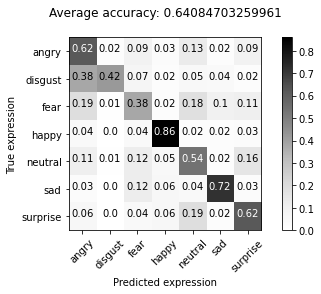

In [38]:
## This method was taken from:
##  https://github.com/nhduong/fer2013icprai2018/blob/master/fer2013_ensemble_mlcnns_testing_icprai2018.ipynb
test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(X_test)
n_test_ins = X_test.shape[0]
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

y_pred_ = model2.predict_generator(generator=test_generator, steps=n_test_ins/batch_size, verbose=1)

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
classes=np.array(('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'))

# Predictions
y_pred = np.argmax(y_pred_, axis=1)
# Ground truth
t_te = np.argmax(test_generator.y, axis=1)

fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,
                      title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [49]:
# Source: https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280 
emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

model3 = load_model('fer2013.hdf5')
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 1)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
        prediction = model3.predict(cropped_img)
        cv2.putText(frame, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
'''
Reference: 
http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.html
https://towardsdatascience.com/clustering-with-k-means-1e07a8bfb7ca
https://github.com/machrisaa/tensorflow-vgg
https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-3-fer2013-c38f2e052280 
https://github.com/nhduong/fer2013icprai2018/blob/master/fer2013_ensemble_mlcnns_testing_icprai2018.ipynb
'''